## Train models on the enhanced data (with all new columns)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import Connection, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

dt = DataTransfer(Connection(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.admissions
"""

df = dt.fetch_data(sql_query)

In [3]:
df.head()

,subject_id,hadm_id,admittime,admit_daytime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,...,hematocrit_csf_max_value,hematocrit_csf_avg_value,hematocrit_csf_ref_range_lower,hematocrit_csf_ref_range_upper,hematocrit_csf_was_abnormal,hematocrit_csf_ratio_abnormal,hematocrit_csf_first_abnormal_charttime,hematocrit_csf_first_test_charttime,hematocrit_csf_last_test_charttime,hematocrit_csf_abnormal_hrs_until_discharge
0,10004113,29879900,2173-03-20 00:00:00,night,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
1,10007785,22943998,2156-05-16 01:36:00,night,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
2,10010888,20162667,2174-01-09 22:19:00,night,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
3,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
4,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN


In [4]:
#encoding
# from sklearn.preprocessing import OneHotEncoder

careunit_dict = {
    'Medicine': 0,
    'Surgical Intensive Care Unit (SICU)': 1,
    'Surgery/Vascular/Intermediate': 2,
    'Neuro Stepdown': 3,
    'PACU': 4,
    'Medical Intensive Care Unit (MICU)': 5,
    'Surgery/Trauma': 6,
    'Med/Surg': 7,
    'Medical/Surgical Intensive Care Unit (MICU/SICU)': 8,
    'Coronary Care Unit (CCU)': 9,
    'Medicine/Cardiology Intermediate': 10,
    'Neuro Intermediate': 11,
    'Neuro Surgical Intensive Care Unit (Neuro SICU)': 12,
    'Cardiac Vascular Intensive Care Unit (CVICU)': 13,
    'Trauma SICU (TSICU)': 14,
    'Intensive Care Unit (ICU)': 15,
    'Neurology': 16
}

df["first_careunit_o"] = df.first_careunit.map(careunit_dict)
df["last_careunit_o"] = df.first_careunit.map(careunit_dict)

admission_type_dict = {
    'AMBULATORY OBSERVATION': 0,
    'DIRECT EMER.': 1,
    'DIRECT OBSERVATION': 2,
    'ELECTIVE': 3,
    'EU OBSERVATION': 4,
    'EW EMER.': 5,
    'OBSERVATION ADMIT': 6,
    'SURGICAL SAME DAY ADMISSION': 7,
    'URGENT': 8
}

df["admission_type_o"] = df.admission_type.map(admission_type_dict)

admission_location_dict = {
    'AMBULATORY SURGERY TRANSFER': 0,
    'CLINIC REFERRAL': 1,
    'EMERGENCY ROOM': 2,
    'INFORMATION NOT AVAILABLE': 3,
    'INTERNAL TRANSFER TO OR FROM PSYCH': 4,
    'PACU': 5,
    'PHYSICIAN REFERRAL': 6,
    'PROCEDURE SITE': 7,
    'TRANSFER FROM HOSPITAL': 8,
    'TRANSFER FROM SKILLED NURSING FACILITY': 9,
    'WALK-IN/SELF REFERRAL': 10
}

df["admission_location_o"] = df.admission_location.map(admission_location_dict)

discharge_location_dict = {
    'ACUTE HOSPITAL': 0,
    'AGAINST ADVICE': 1,
    'ASSISTED LIVING': 2,
    'CHRONIC/LONG TERM ACUTE CARE': 3,
    'DIED': 4,
    'HEALTHCARE FACILITY': 5,
    'HOME': 6,
    'HOME HEALTH CARE': 7,
    'HOSPICE': 8,
    'OTHER FACILITY': 9,
    'PSYCH FACILITY': 10,
    'REHAB': 11,
    'SKILLED NURSING FACILITY': 12

}

df["discharge_location_o"] = df.discharge_location.map(discharge_location_dict)

insurance_dict = {
    'Medicaid': 0,
    'Medicare': 1,
    'No charge': 2,
    'Other': 3,
    'Private': 4
}

df["insurance_o"] = df.insurance.map(insurance_dict)

language_dict = {
    'American Sign Language': 0,
    'Amharic': 1,
    'Arabic': 2,
    'Armenian': 3,
    'Bengali': 4,
    'Chinese': 5,
    'English': 6,
    'French': 7,
    'Haitian': 8,
    'Hindi': 9,
    'Italian': 10,
    'Japanese': 11,
    'Kabuverdianu': 12,
    'Khmer': 13,
    'Korean': 14,
    'Modern Greek (1453-)': 15,
    'Other': 16,
    'Persian': 17,
    'Polish': 18,
    'Portuguese': 19,
    'Russian': 20,
    'Somali': 21,
    'Spanish': 22,
    'Thai': 23,
    'Vietnamese': 24

}

df["language_o"] = df.language.map(language_dict)

df = pd.get_dummies(df, columns=['admit_daytime'])

df = pd.get_dummies(df, columns=['marital_status'])

df = pd.get_dummies(df, columns=['race'])

df = pd.get_dummies(df, columns=['gender'])

df = pd.get_dummies(df, columns=['anchor_year_group'])

df['icd_code_numeric'] = df['icd_code'].replace({
    r'^I61.*': 0,   # Match codes starting with 'I61'
    r'^I63.*': 1,   # Match codes starting with 'I63'
    r'^G41.*': 2    # Match codes starting with 'G41'
}, regex=True)

In [5]:
def fillna_tests(test_name: str, df: pd.DataFrame):
    df[f'{test_name}_min_value'].fillna(-1, inplace=True)
    df[f'{test_name}_max_value'].fillna(-1, inplace=True)
    df[f'{test_name}_avg_value'].fillna(-1, inplace=True)
    df[f'{test_name}_was_abnormal'].fillna(False, inplace=True)
    df[f'{test_name}_ratio_abnormal'].fillna(0, inplace=True)
    df[f'{test_name}_abnormal_hrs_until_discharge'].fillna(-1, inplace=True)

In [6]:
tests = [
    'sodium',
    'sodium_urine',
    'sodium_whole_blood',
    'potassium',
    'potassium_whole_blood',
    'calcium_total',
    'free_calcium',
    'magnesium',
    'glucose',
    'glucose_ascites',
    'glucose_body_fluid', 
    'glucose_csf',
    'lactate',
    'lactate_dehydrogenase_csf',
    'lactate_dehydrogenase_ld',
    'ph',
    'po2',
    'bicarbonate',
    'bicarbonate_urine',
    'calculated_bicarbonate_whole_blood',
    'inr_pt',
    'pt',
    'ptt',
    'crp',
    'white_blood_cells',
    'ammonia',
    'albumin',
    'albumin_creatine_urine',
    'creatinine',
    'creatinine_clearance',
    'creatinine_serum',
    'urea_nitrogen',
    'alt',
    'ast',
    'bilirubin',
    'bilirubin_direct',
    'bilirubin_indirect',
    'bilirubin_total',
    'ratio_hemoglobin_a1c',
    'hemoglobin',
    'hematocrit',
    'hematocrit_csf'
]

In [7]:
for test in tests:
    fillna_tests(test, df)

In [8]:
print(df.columns[df.isnull().sum() > 0])

Index(['deathtime', 'discharge_location', 'insurance', 'language', 'edregtime',
       'edouttime', 'dod', 'sodium_ref_range_lower', 'sodium_ref_range_upper',
       'sodium_first_abnormal_charttime',
       ...
       'hematocrit_first_test_charttime', 'hematocrit_last_test_charttime',
       'hematocrit_csf_ref_range_lower', 'hematocrit_csf_ref_range_upper',
       'hematocrit_csf_first_abnormal_charttime',
       'hematocrit_csf_first_test_charttime',
       'hematocrit_csf_last_test_charttime', 'discharge_location_o',
       'insurance_o', 'language_o'],
      dtype='object', length=220)


In [9]:
columns_to_drop = [column for column in df.columns if any(substring in column for substring in ['range', 'charttime'])]

In [10]:
df.drop(columns=[
    'first_careunit',
    'last_careunit',
    'admission_type',
    'admit_provider_id',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',

    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

In [11]:
print(df.columns[df.isnull().sum() > 0])

Index(['discharge_location_o', 'insurance_o', 'language_o'], dtype='object')


<Axes: >

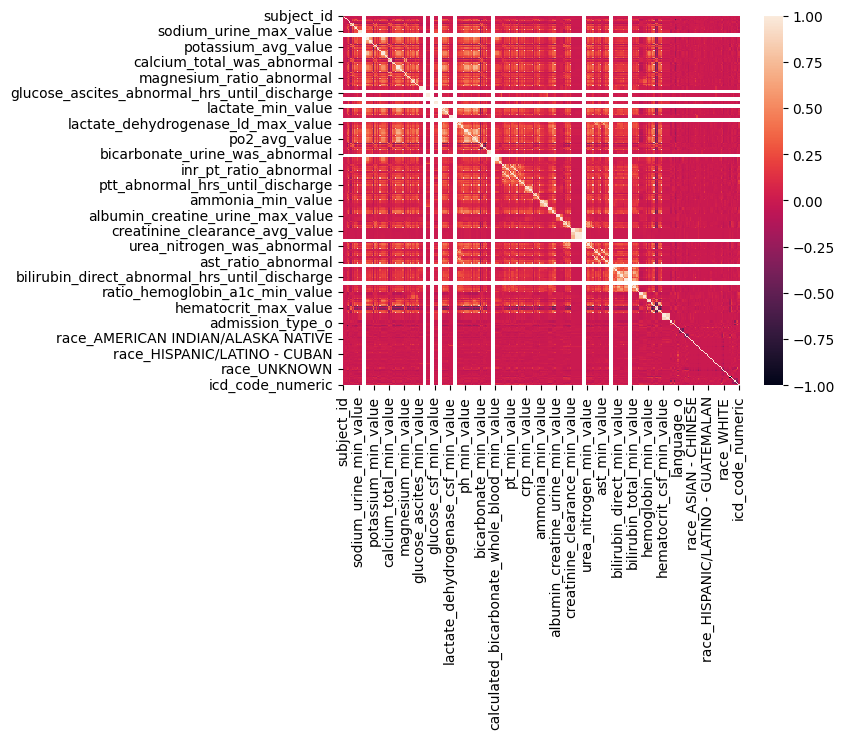

In [12]:
import seaborn as sns
%matplotlib inline

corr = df.corr()

sns.heatmap(corr)

In [13]:
df.corrwith(df['los']).sort_values(ascending=False).head(21)

los                                               1.000000
po2_abnormal_hrs_until_discharge                  0.460077
glucose_abnormal_hrs_until_discharge              0.458163
white_blood_cells_abnormal_hrs_until_discharge    0.452367
hemoglobin_abnormal_hrs_until_discharge           0.451758
ph_abnormal_hrs_until_discharge                   0.451204
hematocrit_abnormal_hrs_until_discharge           0.447066
urea_nitrogen_abnormal_hrs_until_discharge        0.446190
inr_pt_abnormal_hrs_until_discharge               0.444576
sodium_abnormal_hrs_until_discharge               0.443165
pt_abnormal_hrs_until_discharge                   0.442418
calcium_total_abnormal_hrs_until_discharge        0.435033
bicarbonate_abnormal_hrs_until_discharge          0.433116
ptt_abnormal_hrs_until_discharge                  0.403870
free_calcium_abnormal_hrs_until_discharge         0.402980
potassium_abnormal_hrs_until_discharge            0.394434
creatinine_abnormal_hrs_until_discharge           0.3706

In [14]:
print(df.columns[df.isnull().sum() > 0])

Index(['discharge_location_o', 'insurance_o', 'language_o'], dtype='object')


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from ml_utils import learn_models

In [ ]:
initial_results = learn_models(
    models={
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Support Vector Regression': SVR(kernel='rbf'),
        'Decision Tree Regression': DecisionTreeRegressor(max_depth=5),
        'Random Forest Regression': RandomForestRegressor(n_estimators=100, n_jobs=-1),
        'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100)
    },
    df=df,
    folder='initial_train'
)

## Results of training

In [ ]:
initial_results

#### Linear Regression

In [ ]:
features = df.columns.tolist()
features.remove('los')

In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
from ml_utils import extract_feature_importance

top_20_important_features_lr = extract_feature_importance('initial_train', 'Linear Regression', features).head(20)
top_20_important_features_lr_names = top_20_important_features_lr.keys().tolist()
top_20_important_features_lr

#### Ridge Regression

In [ ]:
top_20_important_features_rr = extract_feature_importance('initial_train', 'Ridge Regression', features).head(20)
top_20_important_features_rr_names = top_20_important_features_rr.keys().tolist()
top_20_important_features_rr

#### Lasso Regression

In [ ]:
top_20_important_features_lasso_r = extract_feature_importance('initial_train', 'Lasso Regression', features).head(20)
top_20_important_features_lasso_r_names = top_20_important_features_lasso_r.keys().tolist()
top_20_important_features_lasso_r

#### Decision Tree Regression

In [ ]:
top_20_important_features_dtr = extract_feature_importance('initial_train', 'Decision Tree Regression', features).head(20)
top_20_important_features_dtr_names = top_20_important_features_dtr.keys().tolist()
top_20_important_features_dtr

#### Random Forest Regression

In [ ]:
top_20_important_features_rfr = extract_feature_importance('initial_train', 'Random Forest Regression', features).head(20)
top_20_important_features_rfr_names = top_20_important_features_rfr.keys().tolist()
top_20_important_features_rfr

#### Gradient Boosting Regression

In [ ]:
top_20_important_features_gbr = extract_feature_importance('initial_train', 'Gradient Boosting Regression', features).head(20)
top_20_important_features_gbr_names = top_20_important_features_gbr.keys().tolist()
top_20_important_features_gbr

## Train after feature selection

Now I'll take 20 most important features for each algorithm and will compare the results to the original ones

In [ ]:
top_20_important_features_lr_names.append('los')
top_20_important_features_rr_names.append('los')
top_20_important_features_lasso_r_names.append('los')
top_20_important_features_dtr_names.append('los')
top_20_important_features_rfr_names.append('los')
top_20_important_features_gbr_names.append('los')

In [ ]:
lr_df = df[df.columns.intersection(top_20_important_features_lr_names)]
rr_df = df[df.columns.intersection(top_20_important_features_rr_names)]
lasso_r_df = df[df.columns.intersection(top_20_important_features_lasso_r_names)]
dtr_df = df[df.columns.intersection(top_20_important_features_dtr_names)]
rfr_df = df[df.columns.intersection(top_20_important_features_rfr_names)]
gbr_df = df[df.columns.intersection(top_20_important_features_gbr_names)]

In [ ]:
top_20_features_results = learn_models(
    models={
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Decision Tree Regression': DecisionTreeRegressor(max_depth=5),
        'Random Forest Regression': RandomForestRegressor(n_estimators=100, n_jobs=-1),
        'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100)
    },
    df={
        'Linear Regression': lr_df,
        'Ridge Regression': rr_df,
        'Lasso Regression': lasso_r_df,
        'Decision Tree Regression': dtr_df,
        'Random Forest Regression': rfr_df,
        'Gradient Boosting Regression': gbr_df,
    },
    folder='top_20_features_train'
)

In [ ]:
top_20_features_results

In [ ]:
initial_results